# Original Source Code

This notebook attempts to recreate the study's source code as closely as possible in order to analyze and validate 
that our results are comparable. The only changes were made to make the code run on modern Python and in a way that is
conducive to being run in a notebook.

**GT CSE 6250 Spring Project**
Team A1: Brian Popp, bpopp7@gatech.edu, Danielle Velott, dvellot3@gatech.edu


In [1]:
# Original Authors: Manas Gaur, Amanuel Alambo, Joy Sain, Ugur Kursuncu, 
# Krishnaprasad Thirunarayan, Ramakanth Kavuluru,
# Amit Sheth, Randy Welton, Jyotishman Pathak

import os
import csv
import string

import pandas as pd
import numpy as np
from nltk import word_tokenize
from gensim.test.utils import common_texts
from gensim.models import KeyedVectors, Word2Vec
from keras.utils import to_categorical
import datetime, time
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, Input, MaxPool2D
from keras.layers import Conv2D, GlobalAveragePooling1D, MaxPooling2D
from keras.layers import Concatenate
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, train_test_split
import matplotlib.pyplot as plt


In [2]:

punctuations = list(string.punctuation)

ip_txt_file = './data/500_Reddit_users_posts_labels.csv'  # CSV file: "User", "Post", "Label"
ip_feat_file = './data/External_Features.csv'             # CSV file: "User", "Features"

## adding a limit of 20-50,000 will significantly speed up word2vec building, but will decrease accuracy
w2v_file = {'file': './out/numberbatch-en-19.08.txt.gz', 'is_binary': False, 'limit': None}

op_file = './out/Result_5-Label_Classification.tsv'

severity_classes = {'Supportive': 0, 'Indicator': 1, 'Ideation': 2, 'Behavior': 3, 'Attempt': 4}

sys_params = {'emb_dim': 300,
              'max_sent_len': 1500,
              'str_padd': '@PADD',
              'cross_val': 2}

cnn_params = {'no_filters': 100,
              'kernels': [3, 4, 5],
              'channel': 1,
              'c_stride': (1, sys_params['emb_dim']),
              'pad': 'same',
              'ip_shape': (sys_params['max_sent_len'], sys_params['emb_dim'], 1),
              'c_activ': 'relu',
              'drop_rate': 0.3,
              'dense_1_unit': 128,
              'dense_2_unit': 128,
              'dense_activ': 'relu',
              'op_unit': 5,             # 5-Label classification
              'op_activ': 'softmax',
              'l_rate': 0.001,
              'loss': 'categorical_crossentropy',
              'batch': 4,
              'epoch': 10,
              'verbose': 1}

intermediate_layer = 'flat_drop'    # for extracting features from CNN

print ('\nSystem Parameters: ', sys_params)
print ('\nCNN Parameters: ', cnn_params)


System Parameters:  {'emb_dim': 300, 'max_sent_len': 1500, 'str_padd': '@PADD', 'cross_val': 2}

CNN Parameters:  {'no_filters': 100, 'kernels': [3, 4, 5], 'channel': 1, 'c_stride': (1, 300), 'pad': 'same', 'ip_shape': (1500, 300, 1), 'c_activ': 'relu', 'drop_rate': 0.3, 'dense_1_unit': 128, 'dense_2_unit': 128, 'dense_activ': 'relu', 'op_unit': 5, 'op_activ': 'softmax', 'l_rate': 0.001, 'loss': 'categorical_crossentropy', 'batch': 4, 'epoch': 10, 'verbose': 1}


In [3]:

# Read the input CSV file
def read_ip_file(ip_file):

    padd = sys_params['str_padd']
    max_len = sys_params['max_sent_len']

    x_data, y_data = [], []

    if ip_file:
        with open(ip_file) as csv_file:

            # Exclude the first line (header)
            next(csv_file)
            csv_reader = csv.reader(csv_file, delimiter=',')

            # Loop through each line
            for row in csv_reader:

                sent = row[1].lower()

                # Remove non-ascii characters
                printable = set(string.printable)
                sent = "".join(filter(lambda x: x in printable, sent))

                # Remove punctuation
                # (if item not in punctuations) needed?
                lst_tokens = [item.strip("".join(punctuations)) for item in word_tokenize(sent)]

                # Strip the sentence if it exceeds the max length
                if len(lst_tokens) > max_len:
                    lst_tokens = lst_tokens[:max_len]

                # Padd the sentence if the length is less than max length
                elif len(lst_tokens) < max_len:
                    for j in range(len(lst_tokens), max_len):
                        lst_tokens.append(padd)

                y_data.append(severity_classes[row[2].strip()])
                x_data.append(lst_tokens)

    return x_data, y_data

# Vectorize the input data using pretrained word2vec embedding lookup
def vectorize_data(lst_input):
    print ('Vectorizing data.')
    padd = sys_params['str_padd']
    wv_size = sys_params['emb_dim']

    # Load the pre-trained word2vec model
    if os.path.isfile ( './out/vectors.kv' ):
        w2v_model = KeyedVectors.load('./out/vectors.kv')
    else:
        w2v_model = KeyedVectors.load_word2vec_format(w2v_file['file'], binary=w2v_file['is_binary'], limit=w2v_file['limit'])
        w2v_model.save( './out/vectors.kv' )

    # Get the word2vec vocabulary
    vocab = w2v_model.key_to_index
    #
    padding_zeros = np.zeros(wv_size, dtype=np.float32)

    x_data = []

    # Loop through each sentence
    for sent in lst_input:
        emb = []
        for tok in sent:

            # Zero-padding for padded tokens
            if tok == padd:
                emb.append(list(padding_zeros))

            # Get the token embedding from the word2vec model
            elif tok in vocab:
                emb.append(w2v_model[tok].astype(float).tolist())

            # Zero-padding for out-of-vocab tokens
            else:
                emb.append(list(padding_zeros))

        x_data.append(emb)

    del w2v_model, vocab

    return np.array(x_data)

# Read additional external features
def read_external_features(input_file, feature_file):

    lst_users = []
    feature_dim = 16

    # Read the user_ids from the input file ["User", "Post", "Label"]
    with open(input_file) as f:
        for line in f:
            split = line.strip().split('\t')
            lst_users.append(split[0])

    features = []
    dct_user_featurs = {}

    with open(feature_file) as csv_file:
        # Exclude the header ['User', feature_scores ...]
        next(csv_file)

        # Read the CSV feature file
        csv_reader = csv.reader(csv_file, delimiter=',')

        # Loop through each row
        for row in csv_reader:
            # Start reading from 1-st value as 0-th value is "User"
            # convert the feature score into float
            scores = [float(val) for val in row[1:]]

            # Dictionary that maps: "User" --> "Feature"
            dct_user_featurs[row[0]] = scores

    # Read the features for user in the same sequence as in the input file
    # and add it to a list so that it can be merged easily the CNN generated features in the same sequence
    for user in lst_users:
        # If we have the features for the user then add it to the list
        if user in dct_user_featurs.keys():
            features.append(dct_user_featurs[user])

        # If we don't have features generated for a user, then add zeros
        else:
            features.append(list(np.zeros(feature_dim)))

    return np.array(features)

In [4]:

# Returns the CNN model
def get_cnn_model():
    seq_len = sys_params['max_sent_len']
    emb_dim = sys_params['emb_dim']

    l_ip = Input(shape=(seq_len, emb_dim, 1), dtype='float32')
    lst_convfeat = []
    for filter in cnn_params['kernels']:
        l_conv = Conv2D(filters=cnn_params['no_filters'], kernel_size=(filter, emb_dim), strides=cnn_params['c_stride'],
                        padding=cnn_params['pad'], data_format='channels_last', input_shape=cnn_params['ip_shape'],
                        activation=cnn_params['c_activ'])(l_ip)
        l_pool = MaxPool2D(pool_size=(seq_len, 1))(l_conv)
        lst_convfeat.append(l_pool)

    l_concat = Concatenate(axis=1)(lst_convfeat)
    l_flat = Flatten()(l_concat)
    l_drop = Dropout(rate=cnn_params['drop_rate'], name='flat_drop')(l_flat)

    # l_dense1 = Dense(units=cnn_params['dense_1_unit'], activation=cnn_params['dense_activ'], name='dense_1')(l_flat)
    # l_drop2 = Dropout(rate=cnn_params['drop_rate'])(l_dense1)

    # l_dense2 = Dense(units=cnn_params['dense_2_unit'], activation=cnn_params['dense_activ'], name='dense_2')(l_drop2)

    l_op = Dense(units=cnn_params['op_unit'], activation=cnn_params['op_activ'], name='cnn_op')(l_drop)

    final_model = Model(l_ip, l_op)
    final_model.compile(optimizer=Adam(learning_rate=cnn_params['l_rate']), loss=cnn_params['loss'], metrics=['accuracy'])    # 'categorical_crossentropy'

    return final_model

# Returns a MLP model for final classification
def get_mlp_model(ip_dim):

    mlp_model = Sequential()

    mlp_model.add(Dense(units=cnn_params['op_unit'], activation=cnn_params['op_activ'], name='classif_op',
                            input_dim=ip_dim))
    mlp_model.compile(optimizer=Adam(learning_rate=cnn_params['l_rate']), loss=cnn_params['loss'],
                          metrics=['accuracy'])
    return mlp_model

# Compute Precision, Recall, and F1-score
def get_prf1_score(y_true, y_pred):
    tp, fp, fn = 0.0, 0.0, 0.0
    for i in range(len(y_pred)):
        if y_pred[i] == y_true[i]:
            tp += 1
        elif y_pred[i] > y_true[i]:
            fp += 1
        else:
            fn += 1
    if tp == 0:
        tp = 1.0
    if fp == 0:
        fp = 1.0
    if fn == 0:
        fn  = 1.0
    P = tp / (tp + fp)
    R = tp / (tp + fn)
    F = 2 * P * R / (P + R)
    print ('\nPrecision: {0}\t Recall: {1}\t F1-Score: {2}'.format(P, R, F))
    return {'P': P, 'R': R, 'F': F}



In [5]:
# Read the input file
x_data, y_data = read_ip_file(ip_txt_file)

# Vectorize the data
x_data = vectorize_data(x_data)
ext_feature = read_external_features(ip_txt_file, ip_feat_file)

# Convert into numpy array
x_data, y_data = np.array(x_data), np.array(y_data)
y_data_df = pd.DataFrame ( y_data ) ## used to retrieve indexes

print ( x_data.shape, y_data.shape ) 

Vectorizing data.
(500, 1500, 300) (500,)


## split the data

In [6]:
x_train, x_test, y_train, y_test = train_test_split( x_data , y_data_df, test_size=0.25)
print ( 'train:', x_train.shape, y_train.shape )
print ( 'test:', x_test.shape, y_test.shape )

# Convert the class labels into categorical
y_train_cat, y_test_cat = to_categorical(y_train), to_categorical(y_test)

# Reshape the data for CNN
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

# External features for this particular split
train_ext_feat, test_ext_feat = ext_feature[y_train.index], ext_feature[y_test.index]


train: (375, 1500, 300) (375, 1)
test: (125, 1500, 300) (125, 1)


In [7]:
# CNN model for training on the embedded text input
cnn_model = get_cnn_model()
# print (cnn_model.summary())

# Train the model
cnn_model.fit(x=x_train, y=y_train_cat, batch_size=cnn_params['batch'], epochs=cnn_params['epoch'], verbose=cnn_params['verbose'])

# Trained model for extracting features from intermediate layer
model_feat_extractor = Model(inputs=cnn_model.input, outputs=cnn_model.get_layer(intermediate_layer).output)

# Get CNN gerated features
train_cnn_feat = model_feat_extractor.predict(x_train)
test_cnn_feat = model_feat_extractor.predict(x_test)

# Merge the CNN generated features with the external features
x_train_features = []
for index, cnn_feature in enumerate(train_cnn_feat):
    tmp_feat = list(cnn_feature)
    tmp_feat.extend(list(train_ext_feat[index]))
    x_train_features.append(np.array(tmp_feat))

x_test_features = []
for index, cnn_feature in enumerate(test_cnn_feat):
    tmp_feat = list(cnn_feature)
    tmp_feat.extend(list(test_ext_feat[index]))
    x_test_features.append(np.array(tmp_feat))

# Convert the list into numpy array
x_train_features = np.array(x_train_features)
x_test_features = np.array(x_test_features)

del train_cnn_feat, test_cnn_feat

# Get the MLP model for final classification
mlp_model = get_mlp_model(ip_dim = len(x_train_features[0]))
print (mlp_model.summary())

tc = time.time()

# Train the MLP model
mlp_model.fit(x=x_train_features, y=y_train_cat, batch_size=cnn_params['batch'], epochs=cnn_params['epoch'], verbose=cnn_params['verbose'])

print ('\nTime elapsed in training CNN: ', str(datetime.timedelta(seconds=time.time() - tc)))
# del x_train, y_train

print ('\nEvaluating on Test data...\n')
# # Print Loss and Accuracy
model_metrics = mlp_model.evaluate(x_test_features, y_test_cat)

for i in range(len(model_metrics)):
    print (mlp_model.metrics_names[i], ': ', model_metrics[i])

y_pred = mlp_model.predict(x_test_features)
y_pred = np.argmax(y_pred, axis=-1)
# y_test = np.argmax(y_test_cat, axis=-1)

# Scikit-learn classification report (P, R, F1, Support)
report = classification_report(y_test, y_pred)
print (report)

Epoch 1/10
94/94 [==============================] - 15s 143ms/step - loss: 1.5248 - accuracy: 0.3467
Epoch 2/10
94/94 [==============================] - 13s 143ms/step - loss: 1.4472 - accuracy: 0.4133
Epoch 3/10
94/94 [==============================] - 14s 153ms/step - loss: 1.2485 - accuracy: 0.5093
Epoch 4/10
94/94 [==============================] - 14s 150ms/step - loss: 1.0568 - accuracy: 0.5973
Epoch 5/10
94/94 [==============================] - 14s 149ms/step - loss: 0.9149 - accuracy: 0.7227
Epoch 6/10
94/94 [==============================] - 14s 154ms/step - loss: 0.6883 - accuracy: 0.8400
Epoch 7/10
94/94 [==============================] - 14s 153ms/step - loss: 0.5366 - accuracy: 0.8880
Epoch 8/10
94/94 [==============================] - 14s 152ms/step - loss: 0.3897 - accuracy: 0.9520
Epoch 9/10
94/94 [==============================] - 14s 150ms/step - loss: 0.2858 - accuracy: 0.9813
Epoch 10/10
4/4 [==============================] - 1s 304ms/step
Model: "sequential"
______

C:\Program Files\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Program Files\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Program Files\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


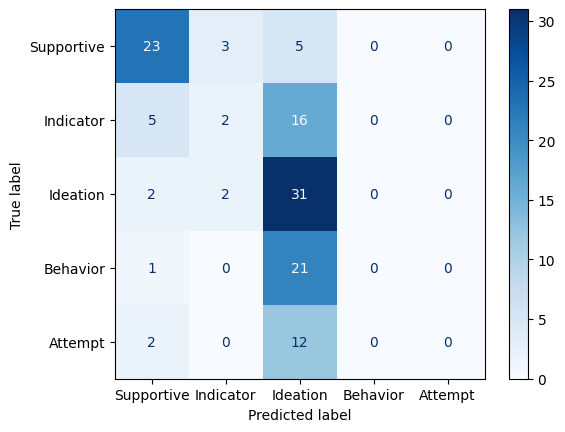

In [8]:
ConfusionMatrixDisplay(confusion_matrix ( y_test, y_pred ), 
          display_labels=list(severity_classes.keys()) )\
  .plot(cmap=plt.cm.Blues);